<a href="https://colab.research.google.com/github/jyothissJayadev/HandWritten_Digit_Reader/blob/main/Depp_learnig__level2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [59]:
import torch
import torchvision
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F

In [60]:
dataset = MNIST(root='data/', download=True)

In [61]:
test_dataset = MNIST(root='data/',
                     train=False,
                     transform=transforms.ToTensor())

In [62]:
import matplotlib.pyplot as plt
%matplotlib inline

In [63]:
dataset = MNIST(root='data/',
                train=True,
                transform=transforms.ToTensor())

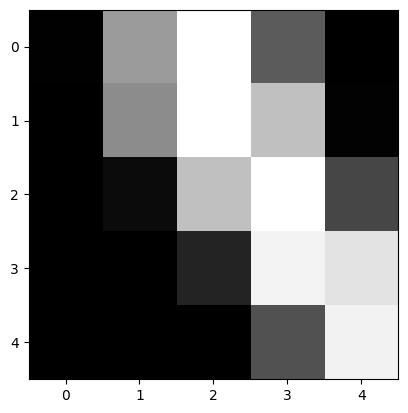

In [64]:
image,label=dataset[0]
plt.imshow(image[0,10:15,10:15], cmap='gray');


In [65]:
train_ds, val_ds = random_split(dataset, [50000, 10000])
len(train_ds), len(val_ds)
batch_size=128
train_dl=DataLoader(train_ds,batch_size,shuffle=True)
val_dl=DataLoader(val_ds,batch_size)

In [66]:
input_size=28*28
output_size=10
model=nn.Linear(input_size, output_size)
model.weight

Parameter containing:
tensor([[ 0.0313,  0.0220,  0.0218,  ..., -0.0027,  0.0009, -0.0295],
        [-0.0113,  0.0276,  0.0084,  ...,  0.0131,  0.0294,  0.0345],
        [-0.0012,  0.0263,  0.0168,  ..., -0.0220, -0.0001, -0.0045],
        ...,
        [ 0.0351, -0.0279,  0.0140,  ...,  0.0211,  0.0074,  0.0238],
        [ 0.0118,  0.0076, -0.0008,  ..., -0.0243, -0.0136, -0.0311],
        [ 0.0288,  0.0069, -0.0014,  ...,  0.0237, -0.0284, -0.0084]],
       requires_grad=True)

In [67]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return out
model=MnistModel()

In [68]:
list(model.parameters())

[Parameter containing:
 tensor([[ 0.0089, -0.0098, -0.0252,  ...,  0.0188,  0.0334, -0.0193],
         [-0.0188, -0.0121, -0.0137,  ..., -0.0108, -0.0279,  0.0162],
         [-0.0255,  0.0336, -0.0054,  ..., -0.0205,  0.0127, -0.0250],
         ...,
         [ 0.0285, -0.0330,  0.0155,  ...,  0.0272, -0.0053,  0.0242],
         [-0.0131,  0.0228,  0.0224,  ..., -0.0252, -0.0335, -0.0035],
         [ 0.0286, -0.0276,  0.0086,  ..., -0.0042,  0.0135,  0.0304]],
        requires_grad=True),
 Parameter containing:
 tensor([-0.0156,  0.0154, -0.0353,  0.0021,  0.0188,  0.0229, -0.0344,  0.0274,
         -0.0212, -0.0037], requires_grad=True)]

In [69]:
for images, labels in train_dl:
    print(images.shape)
    outputs = model(images)
    break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)

torch.Size([128, 1, 28, 28])
outputs.shape :  torch.Size([128, 10])
Sample outputs :
 tensor([[ 0.2350,  0.3481,  0.0213, -0.0947, -0.1288,  0.0872, -0.1701, -0.2246,
          0.1034,  0.1169],
        [ 0.2180,  0.4326, -0.1878, -0.0875, -0.0309, -0.2427, -0.1583,  0.0429,
         -0.0272,  0.0508]])


In [70]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [71]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [88]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return out

    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

model = MnistModel()

In [85]:
def fit(epochs, lr, model, train_dl, val_dl, opt_func=torch.optim.SGD):
    optimizer = opt_func(model.parameters(), lr)
    history = [] # for recording epoch-wise results

    for epoch in range(epochs):

        # Training Phase
        for batch in train_dl:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # Validation phase
        result = evaluate(model, val_dl)
        model.epoch_end(epoch, result)
        history.append(result)

    return history

In [89]:
history2 = fit(5, 0.001, model, train_dl, val_dl)

Epoch [0], val_loss: 1.9571, val_acc: 0.6331
Epoch [1], val_loss: 1.6838, val_acc: 0.7414
Epoch [2], val_loss: 1.4798, val_acc: 0.7748
Epoch [3], val_loss: 1.3260, val_acc: 0.7924
Epoch [4], val_loss: 1.2079, val_acc: 0.8030


In [90]:
history2 = fit(5, 0.001, model, train_dl, val_dl)

Epoch [0], val_loss: 1.1155, val_acc: 0.8131
Epoch [1], val_loss: 1.0416, val_acc: 0.8194
Epoch [2], val_loss: 0.9813, val_acc: 0.8236
Epoch [3], val_loss: 0.9311, val_acc: 0.8268
Epoch [4], val_loss: 0.8888, val_acc: 0.8306


In [91]:
history2 = fit(5, 0.001, model, train_dl, val_dl)

Epoch [0], val_loss: 0.8527, val_acc: 0.8335
Epoch [1], val_loss: 0.8213, val_acc: 0.8358
Epoch [2], val_loss: 0.7940, val_acc: 0.8381
Epoch [3], val_loss: 0.7698, val_acc: 0.8422
Epoch [4], val_loss: 0.7483, val_acc: 0.8446


In [92]:
history2 = fit(5, 0.001, model, train_dl, val_dl)

Epoch [0], val_loss: 0.7291, val_acc: 0.8456
Epoch [1], val_loss: 0.7117, val_acc: 0.8476
Epoch [2], val_loss: 0.6959, val_acc: 0.8488
Epoch [3], val_loss: 0.6816, val_acc: 0.8511
Epoch [4], val_loss: 0.6684, val_acc: 0.8528


In [93]:
history2 = fit(5, 0.001, model, train_dl, val_dl)

Epoch [0], val_loss: 0.6563, val_acc: 0.8536
Epoch [1], val_loss: 0.6451, val_acc: 0.8555
Epoch [2], val_loss: 0.6347, val_acc: 0.8569
Epoch [3], val_loss: 0.6251, val_acc: 0.8585
Epoch [4], val_loss: 0.6161, val_acc: 0.8596


In [94]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds = torch.max(yb, dim=1)
    return preds[0].item()

Label: 9 , Predicted: 9


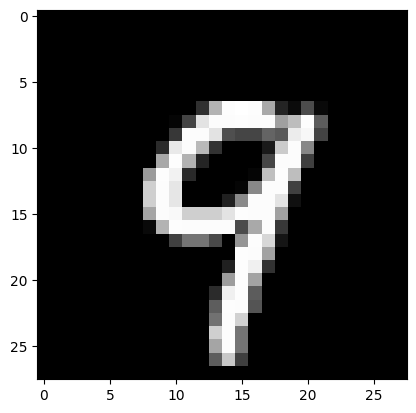

In [99]:
image, label = test_dataset[12]
plt.imshow(image[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(image, model))

Label: 0 , Predicted: 0


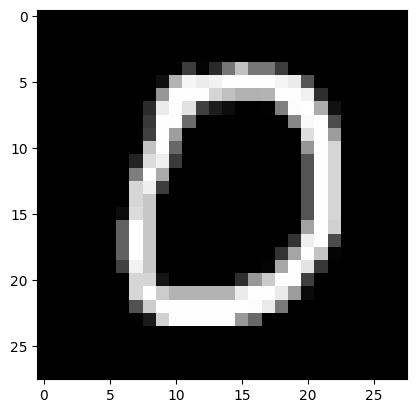

In [100]:
image, label = test_dataset[10]
plt.imshow(image[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(image, model))

Label: 3 , Predicted: 3


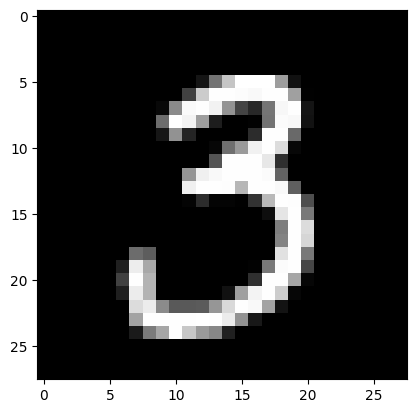

In [101]:
image, label = test_dataset[90]
plt.imshow(image[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(image, model))

Label: 5 , Predicted: 5


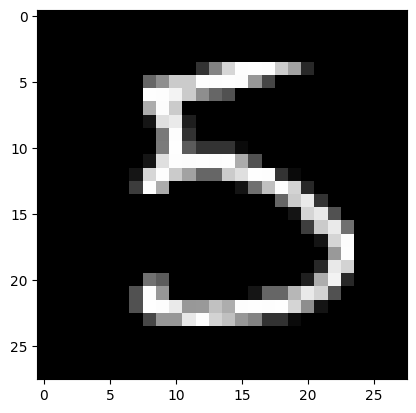

In [98]:
image, label = test_dataset[15]
plt.imshow(image[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(image, model))